# Advanced ML Assignment 2 - Covid Prediction Models with Image Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

In [2]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

In [21]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [22]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
# preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

In [23]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [24]:
len(image_filepaths)

4032

In [25]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [26]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


# Visualizing Covid Images

The top row of images are COVID images, while the bottom row are non-COVID images

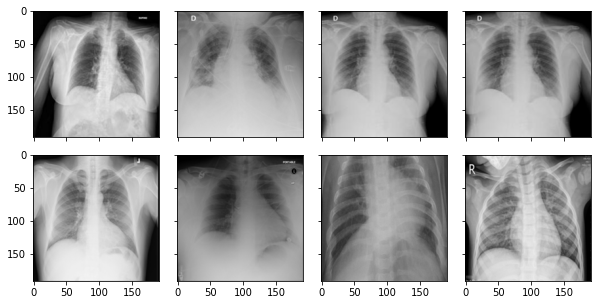

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[0][2])
im4 =preprocessor(fnames[0][2])
im5 =preprocessor(fnames[1][0])
im6 =preprocessor(fnames[1][1])
im7 =preprocessor(fnames[2][0])
im8 =preprocessor(fnames[2][1])

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

# Discussion of Dataset

**Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain**

The Dataset is comprised of thousands of chest X-Ray images that fall into 3 categories: COVID-19 positive, Normal, and Viral Pneumonia. 

The reason this dataset is useful to build predictive models from is that it could be used by epidemiologists and doctors for detecting the presence of viral illnesses such as COVID and Pneumonia, especially when they do not have access to testing kits. X-Rays are widely used medical techology and available to medical professionals world-wide, and in the event of an outbreak, they could simply take X-rays of patients lungs and use the model to help make a determination of whether or not a patient has a particular illness. This could be extremely useful in remote areas or areas without access to other types of advanced testing equipment, and help medical professionals potentially identify an outbreak sooner and take quick action to prevent the spread of COVID in particular

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
from google.colab import files

with open('X_train', 'w') as f:
  f.write('X_train')

files.download('X_train.pkl')

In [41]:
X_test.shape

(1291, 192, 192, 3)

# Model 1 (Sequential)

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model_1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model_1.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 643s 9s/step - loss: 0.8849 - accuracy: 0.5584 - val_loss: 0.6809 - val_accuracy: 0.7067
Epoch 2/5
69/69 [==============================] - 642s 9s/step - loss: 0.6629 - accuracy: 0.6852 - val_loss: 0.5727 - val_accuracy: 0.7577
Epoch 3/5
69/69 [==============================] - 639s 9s/step - loss: 0.4864 - accuracy: 0.7810 - val_loss: 0.4103 - val_accuracy: 0.8288
Epoch 4/5
69/69 [==============================] - 640s 9s/step - loss: 0.3801 - accuracy: 0.8504 - val_loss: 0.3562 - val_accuracy: 0.8780
Epoch 5/5
69/69 [==============================] - 640s 9s/step - loss: 0.3087 - accuracy: 0.8759 - val_loss: 0.3260 - val_accuracy: 0.8761


In [ ]:
model_1.save("model_1.h5", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
# Reload model and data
import tensorflow as tf
model_1 = tf.keras.models.load_model('model_1.h5',compile=False)
model_1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model_1.summary()

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f16245a93a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 3s 47ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model_1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

# Model 2 - VGG16 (Transfer Learning)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:

# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(32, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model_2 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model_2.summary()

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model_2.fit(X_train, y_train,batch_size=1,
          epochs = 3, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/3
2187/2192 [============================>.] - ETA: 0s - loss: 1.1123 - acc: 0.3301
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 34s 11ms/step - loss: 1.1123 - acc: 0.3298 - val_loss: 1.1007 - val_acc: 0.3406 - lr: 0.0100
Epoch 2/3
2189/2192 [============================>.] - ETA: 0s - loss: 1.0993 - acc: 0.3554
Epoch 00002: val_acc did not improve from 0.34062
2192/2192 [==============================] - 24s 11ms/step - loss: 1.0992 - acc: 0.3554 - val_loss: 1.1033 - val_acc: 0.3206 - lr: 0.0100
Epoch 3/3
2188/2192 [============================>.] - ETA: 0s - loss: 1.1008 - acc: 0.3314
Epoch 00003: val_acc did not improve from 0.34062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 23s 10ms/step - loss: 1.1006 - acc: 0.3326 - val_loss: 1.1014 - val_acc: 0.3388 - lr: 0.0100


In [ ]:
model_2.save("model_2.h5", save_format="h5")

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_2, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 9s 138ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

# Model 3 - Sequential

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model_3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model_3.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 19s 148ms/step - loss: 1.0496 - accuracy: 0.4156 - val_loss: 1.0983 - val_accuracy: 0.3388
Epoch 2/5
69/69 [==============================] - 8s 110ms/step - loss: 0.8270 - accuracy: 0.6036 - val_loss: 0.6002 - val_accuracy: 0.7341
Epoch 3/5
69/69 [==============================] - 8s 111ms/step - loss: 0.6149 - accuracy: 0.7208 - val_loss: 0.6073 - val_accuracy: 0.7195
Epoch 4/5
69/69 [==============================] - 7s 108ms/step - loss: 0.5657 - accuracy: 0.7336 - val_loss: 0.5415 - val_accuracy: 0.7614
Epoch 5/5
69/69 [==============================] - 8s 109ms/step - loss: 0.5037 - accuracy: 0.7632 - val_loss: 0.4758 - val_accuracy: 0.7887


In [ ]:
model_3.save("model_3.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model_3 = tf.keras.models.load_model('model_3.h5',compile=False)
model_3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_3, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fd1af01a670>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

#First 3 Models Overview

I trained and fit 3 initial models. All 3 models were Sequential models, 1 of which was a Transfer Lerning Model (VGG16) using imagenet weights. 

Interestingly, although the first sequential model had the least number of layers and trainable parameters, it performed the best of the 3, with an f1 score of 88.36% and precision of 88.78%. The third model used the same basic architecutre as the first model but stacked more convolutional layers before MaxPooling. However, this model failed to outperform the first model. Of the 3 models, the VGG16 transfer learning model performed very poorly, with an f1 score of 16.66% and precision of 11.1%. Part of the reason for this is likely due to the low number of epochs that were set when fitting the model. Unfortunately, resources are limited in Colab and this model seemed to suffer from such a small number of epochs among other things.

# Model 4 - Inception V3 (Transfer)

In [ ]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = InceptionV3(input_shape=(192,192,3),
                                               include_top=False,
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

In [ ]:
base_model.trainable = False

base_model.summary() 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(flat1)

# define new model
model_4 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 95, 95, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d_13[0][0]']              
 alization)                                                                                       
                                                                                            

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  #mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model_4.fit(X_train, y_train,batch_size=1,
          epochs = 3, verbose=1,validation_split=.2) #callbacks=[mc,red_lr]

Epoch 1/3
2192/2192 [==============================] - 60s 25ms/step - loss: 76.9976 - acc: 0.7523 - val_loss: 97.1526 - val_acc: 0.6940
Epoch 2/3
2192/2192 [==============================] - 54s 25ms/step - loss: 44.6479 - acc: 0.8426 - val_loss: 33.5812 - val_acc: 0.8761
Epoch 3/3
2192/2192 [==============================] - 52s 24ms/step - loss: 32.0806 - acc: 0.8814 - val_loss: 31.5128 - val_acc: 0.8944


In [ ]:
model_4.save("model_4.h5", save_format="h5")

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_4, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fd0444044c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_4.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 6s 77ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

#Model 5 - ResNet50

In [ ]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = ResNet50(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

In [5]:
base_model.trainable = False

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(flat1)

# define new model
model_5 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model_5.summary()

In [8]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_5.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model_5.fit(X_train, y_train,batch_size=1,
          epochs = 5, verbose=1,validation_split=.2, callbacks=[mc,red_lr])

Epoch 1/5
2192/2192 [==============================] - ETA: 0s - loss: 185.8692 - acc: 0.3663
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 56s 21ms/step - loss: 185.8692 - acc: 0.3663 - val_loss: 166.1916 - val_acc: 0.3406 - lr: 0.0100
Epoch 2/5
2188/2192 [============================>.] - ETA: 0s - loss: 160.3878 - acc: 0.3885
Epoch 00002: val_acc did not improve from 0.34062
2192/2192 [==============================] - 39s 18ms/step - loss: 160.3369 - acc: 0.3887 - val_loss: 348.1394 - val_acc: 0.3388 - lr: 0.0100
Epoch 3/5
2192/2192 [==============================] - ETA: 0s - loss: 142.0010 - acc: 0.4649
Epoch 00003: val_acc did not improve from 0.34062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 37s 17ms/step - loss: 142.0010 - acc: 0.4649 - val_loss: 254.2583 - val_acc: 0.3406 - lr: 0.0100
Epoch 4/5
2190/2192 [=========

In [9]:
model_5.save("model_5.h5", save_format="h5")

In [12]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [14]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_5, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [15]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('/content/drive/MyDrive/Covid Train Test Split/X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('/content/drive/MyDrive/Covid Train Test Split/y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_5.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 5s 80ms/step


In [16]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

# Model 6 - Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5, 
                    validation_split=0.2
                    )

In [6]:
train_data_gen = image_gen_train.flow(X_train, y_train, batch_size=128,subset='training',seed=7)
val_data_gen = image_gen_train.flow(X_train, y_train, batch_size=128,subset='validation',seed=7)

In [7]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_6 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

In [8]:
model_6.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [11]:
history = model_6.fit(
    train_data_gen,
    steps_per_epoch=(len(X_train)*0.8)//128,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=(len(X_train)*0.2)//128)

Epoch 1/5
17/17 [==============================] - 43s 1s/step - loss: 1.0998 - accuracy: 0.3370 - val_loss: 1.0983 - val_accuracy: 0.3477
Epoch 2/5
17/17 [==============================] - 27s 2s/step - loss: 1.0991 - accuracy: 0.3259 - val_loss: 1.0999 - val_accuracy: 0.3262
Epoch 3/5
17/17 [==============================] - 25s 1s/step - loss: 1.0997 - accuracy: 0.3346 - val_loss: 1.0994 - val_accuracy: 0.3184
Epoch 4/5
17/17 [==============================] - 26s 2s/step - loss: 1.0987 - accuracy: 0.3293 - val_loss: 1.0985 - val_accuracy: 0.3496
Epoch 5/5
17/17 [==============================] - 30s 2s/step - loss: 1.0986 - accuracy: 0.3327 - val_loss: 1.0988 - val_accuracy: 0.3242


In [13]:
model_6.save("model_6.h5", save_format="h5")

In [3]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [5]:
# Reload model and data
import tensorflow as tf
model_6 = tf.keras.models.load_model('model_6.h5',compile=False)
model_6.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [6]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_6, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [7]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('/content/drive/MyDrive/Covid Train Test Split/X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('/content/drive/MyDrive/Covid Train Test Split/y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model_6.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 9s 40ms/step


In [8]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

# Additional Model Training Overview & Recap

After the first 3 sequential models, I used transfer learning for 2 additional models. The first additional model (Model 4) that I trained was an Inception V3 model using the imagenet weights which is a Functional model. SGD optimization seemed to work well for this model which performed quite well, yielding an f1 score of 86.77% an precision score of 87.81%. Next I used transfer learning once more to train a ResNet50 model, which did not perform as well as the Inception V3 model. Here I trained the model for just 5 epochs, due to limited resources. Model checkpoints were used to reduce the learning rate, and as the learning rate was reduced, the validation accuracy subsequently improved. However, because I was unable to train as many epochs as desired, this model did not predict as well, with an f1 score of 64.46% and precision score of	70.52%. Had I run more epochs I believe the precision and f1 scores would have increased substantially.

I finally trained a Sequential model with augemented data (Model 6), however this model performed surprisingly poorly with an f1 score and precision scores both below 20%. I suspect that the lack of training resources also hindered this model from predicting better. 

Overall the best Model for prediction ended up being Model 1, the very first Sequential Model that I trained and fit, with all other models failing to achieve a higher f1 or precision score. 

Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145